LOADING OF TOKENISED DATASET

In [1]:
import numpy as np
import pandas as pd
import gensim.downloader as api

In [2]:
# Load tokenised dataset (replace with the actual path to your CSV file)
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/tokenized_data.csv')
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,sentence,label,tokens
0,0,beyoncé giselle knowlescarter biːˈjɒnseɪ beeyo...,sentence,"['beyoncé', 'giselle', 'knowlescarter', 'biːˈj..."
1,1,born and raised in houston texas she performed...,sentence,"['born', 'and', 'raised', 'in', 'houston', 'te..."
2,2,managed by her father mathew knowles the group...,sentence,"['managed', 'by', 'her', 'father', 'mathew', '..."
3,3,their hiatus saw the release of beyoncés debut...,sentence,"['their', 'hiatus', 'saw', 'the', 'release', '..."
4,4,following the disbandment of destinys child in...,sentence,"['following', 'the', 'disbandment', 'of', 'des..."


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import gensim.downloader as api
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

In [4]:
data['sentence'] = data['sentence'].fillna("")

VECTORISATION TECHNIQUES

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['tokens'])


In [6]:
# Word2Vec Vectorization

# Convert the 'sentence' column to strings before splitting
sentences = [str(sentence).split() for sentence in data['sentence']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

word2vec_matrix = np.array([sentence_vector(sentence, word2vec_model) for sentence in sentences])

word2vec_matrix

array([[ 0.05358343,  0.36498013, -0.30585384, ..., -0.03458776,
         0.44244993,  0.21650919],
       [ 0.31182188,  0.35450491, -0.85584033, ..., -1.02891648,
         0.11239856,  0.30338761],
       [ 0.4448992 ,  0.37095183, -0.62553996, ..., -0.71702176,
         0.02495562,  0.69060117],
       ...,
       [-0.54572415, -0.0078485 ,  0.24933463, ..., -0.17726775,
         0.06555521, -0.05834945],
       [-0.29968032,  0.52876276, -0.3002494 , ..., -0.59295774,
        -1.16054106,  0.80486298],
       [-0.03079364,  0.07471314,  0.01079732, ..., -0.10349315,
         0.0127647 , -0.06264079]])

In [7]:
# GloVe Vectorization
glove_model = api.load("glove-wiki-gigaword-100")

def sentence_vector_glove(sentence, model):
    vectors = [model[word] for word in sentence if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

glove_matrix = np.array([sentence_vector_glove(sentence, glove_model) for sentence in sentences])

In [9]:
glove_matrix

array([[ 0.18635473, -0.0691494 ,  0.2947875 , ..., -0.34648466,
         0.17919716, -0.193354  ],
       [ 0.15387073,  0.1174821 ,  0.11447229, ..., -0.24451023,
         0.55286026, -0.00613279],
       [ 0.04056289,  0.02154812,  0.29913786, ..., -0.25621215,
         0.30302817,  0.05973475],
       ...,
       [ 0.1444    ,  0.23978999,  0.96692997, ..., -0.72424001,
        -0.22632   , -0.030972  ],
       [-0.0586172 ,  0.26238999,  0.64777601, ..., -0.51606405,
         0.27692601,  0.48316798],
       [-1.44589996, -0.70266002,  0.90666002, ..., -1.79830003,
         0.026794  , -0.99422002]])

In [8]:
# N-grams Vectorization

ngram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=5000)
ngram_matrix = ngram_vectorizer.fit_transform(data['sentence'])
ngram_matrix

<235110x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 971690 stored elements in Compressed Sparse Row format>

MODELLING AND CLASSIFICATION

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])  # 'question'=1, 'sentence'=0

# Split data for each vectorizer
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(word2vec_matrix, y, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, _, _ = train_test_split(glove_matrix, y, test_size=0.2, random_state=42)
X_train_ngram, X_test_ngram, _, _ = train_test_split(ngram_matrix, y, test_size=0.2, random_state=42)

In [ ]:
# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
print("Logistic Regression (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

# Logistic Regression with Word2Vec
lr_word2vec = LogisticRegression()
lr_word2vec.fit(X_train_w2v, y_train)
y_pred_word2vec = lr_word2vec.predict(X_test_w2v)
print("Logistic Regression (Word2Vec) Accuracy:", accuracy_score(y_test, y_pred_word2vec))
print(classification_report(y_test, y_pred_word2vec))

# Logistic Regression with GloVe
lr_glove = LogisticRegression()
lr_glove.fit(X_train_glove, y_train)
y_pred_glove = lr_glove.predict(X_test_glove)
print("Logistic Regression (GloVe) Accuracy:", accuracy_score(y_test, y_pred_glove))
print(classification_report(y_test, y_pred_glove))

# Logistic Regression with N-grams
lr_ngram = LogisticRegression()
lr_ngram.fit(X_train_ngram, y_train)
y_pred_ngram = lr_ngram.predict(X_test_ngram)
print("Logistic Regression (N-grams) Accuracy:", accuracy_score(y_test, y_pred_ngram))
print(classification_report(y_test, y_pred_ngram))

Logistic Regression (TF-IDF) Accuracy: 0.975756029092765
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     26418
           1       0.97      0.98      0.97     20604

    accuracy                           0.98     47022
   macro avg       0.98      0.98      0.98     47022
weighted avg       0.98      0.98      0.98     47022

Logistic Regression (Word2Vec) Accuracy: 0.9700991025477436
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     26418
           1       0.96      0.97      0.97     20604

    accuracy                           0.97     47022
   macro avg       0.97      0.97      0.97     47022
weighted avg       0.97      0.97      0.97     47022

Logistic Regression (GloVe) Accuracy: 0.8355875972948833
              precision    recall  f1-score   support

           0       0.85      0.86      0.85     26418
           1       0.81      0.81      0.81     20604

    accu

In [10]:
from sklearn.metrics import accuracy_score, classification_report

rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_rf = rf_tfidf.predict(X_test_tfidf)
print("Random Forest (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_tfidf_rf))
print(classification_report(y_test, y_pred_tfidf_rf))



Random Forest (TF-IDF) Accuracy: 0.9746288971119901
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     26418
           1       0.97      0.97      0.97     20604

    accuracy                           0.97     47022
   macro avg       0.97      0.97      0.97     47022
weighted avg       0.97      0.97      0.97     47022



In [11]:
rf_word2vec = RandomForestClassifier(n_estimators=100, random_state=42)
rf_word2vec.fit(X_train_w2v, y_train)
y_pred_word2vec_rf = rf_word2vec.predict(X_test_w2v)
print("Random Forest (Word2Vec) Accuracy:", accuracy_score(y_test, y_pred_word2vec_rf))
print(classification_report(y_test, y_pred_word2vec_rf))


Random Forest (Word2Vec) Accuracy: 0.950959125515716
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     26418
           1       0.95      0.94      0.94     20604

    accuracy                           0.95     47022
   macro avg       0.95      0.95      0.95     47022
weighted avg       0.95      0.95      0.95     47022



In [12]:
rf_ngram = RandomForestClassifier(n_estimators=100, random_state=42)
rf_ngram.fit(X_train_ngram, y_train)
y_pred_ngram_rf = rf_ngram.predict(X_test_ngram)
print("Random Forest (N-grams) Accuracy:", accuracy_score(y_test, y_pred_ngram_rf))
print(classification_report(y_test, y_pred_ngram_rf))


Random Forest (N-grams) Accuracy: 0.858576836374463
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     26418
           1       0.83      0.85      0.84     20604

    accuracy                           0.86     47022
   macro avg       0.86      0.86      0.86     47022
weighted avg       0.86      0.86      0.86     47022



In [13]:
rf_glove = RandomForestClassifier(n_estimators=100, random_state=42)
rf_glove.fit(X_train_glove, y_train)
y_pred_glove_rf = rf_glove.predict(X_test_glove)
print("Random Forest (GloVe) Accuracy:", accuracy_score(y_test, y_pred_glove_rf))
print(classification_report(y_test, y_pred_glove_rf))


Random Forest (GloVe) Accuracy: 0.8670834928331419
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     26418
           1       0.88      0.80      0.84     20604

    accuracy                           0.87     47022
   macro avg       0.87      0.86      0.86     47022
weighted avg       0.87      0.87      0.87     47022



In [14]:
from sklearn.naive_bayes import BernoulliNB

nb_tfidf = BernoulliNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf_nb = nb_tfidf.predict(X_test_tfidf)
print("Bernoulli NB (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_tfidf_nb))
print(classification_report(y_test, y_pred_tfidf_nb))


Bernoulli NB (TF-IDF) Accuracy: 0.8958359916634767
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     26418
           1       0.94      0.81      0.87     20604

    accuracy                           0.90     47022
   macro avg       0.90      0.89      0.89     47022
weighted avg       0.90      0.90      0.89     47022



In [15]:
nb_word2vec = BernoulliNB()
nb_word2vec.fit(X_train_w2v, y_train)
y_pred_word2vec_nb = nb_word2vec.predict(X_test_w2v)
print("Bernoulli NB (Word2Vec) Accuracy:", accuracy_score(y_test, y_pred_word2vec_nb))
print(classification_report(y_test, y_pred_word2vec_nb))


Bernoulli NB (Word2Vec) Accuracy: 0.8180213517077113
              precision    recall  f1-score   support

           0       0.86      0.80      0.83     26418
           1       0.77      0.84      0.80     20604

    accuracy                           0.82     47022
   macro avg       0.82      0.82      0.82     47022
weighted avg       0.82      0.82      0.82     47022



In [16]:
nb_glove = BernoulliNB()
nb_glove.fit(X_train_glove, y_train)
y_pred_glove_nb = nb_glove.predict(X_test_glove)
print("Bernoulli NB (GloVe) Accuracy:", accuracy_score(y_test, y_pred_glove_nb))
print(classification_report(y_test, y_pred_glove_nb))


Bernoulli NB (GloVe) Accuracy: 0.7334864531495896
              precision    recall  f1-score   support

           0       0.78      0.74      0.76     26418
           1       0.68      0.73      0.71     20604

    accuracy                           0.73     47022
   macro avg       0.73      0.73      0.73     47022
weighted avg       0.74      0.73      0.73     47022



In [17]:
nb_ngram = BernoulliNB()
nb_ngram.fit(X_train_ngram, y_train)
y_pred_ngram_nb = nb_ngram.predict(X_test_ngram)
print("Bernoulli NB (N-grams) Accuracy:", accuracy_score(y_test, y_pred_ngram_nb))
print(classification_report(y_test, y_pred_ngram_nb))


Bernoulli NB (N-grams) Accuracy: 0.8482625154183149
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     26418
           1       0.88      0.75      0.81     20604

    accuracy                           0.85     47022
   macro avg       0.86      0.84      0.84     47022
weighted avg       0.85      0.85      0.85     47022



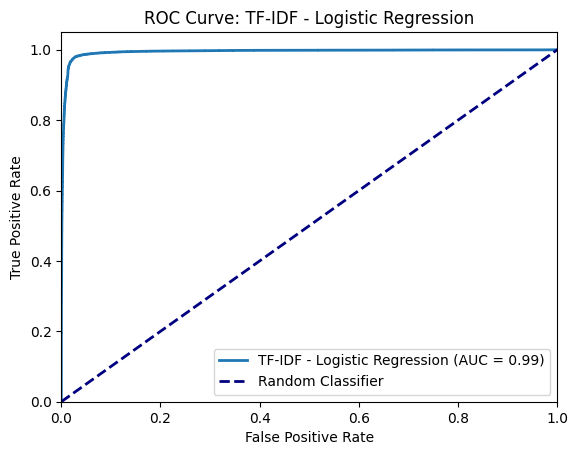

In [12]:
from sklearn.metrics import roc_curve, auc

# Initialize and train Logistic Regression model
lr_model_tfidf = LogisticRegression()  # Creating a Logistic Regression model
lr_model_tfidf.fit(X_train_tfidf, y_train)  # Train the model

# Get predicted probabilities for the positive class
y_score = lr_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='TF-IDF - Logistic Regression (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: TF-IDF - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


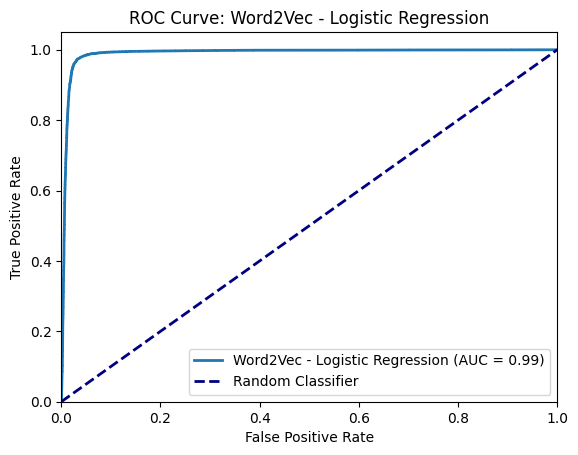

In [13]:
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression model using Word2Vec features
lr_model_w2v = LogisticRegression()
lr_model_w2v.fit(X_train_w2v, y_train)

# Get predicted probabilities for the positive class
y_score_w2v = lr_model_w2v.predict_proba(X_test_w2v)[:, 1]

# Compute ROC curve and AUC
fpr_w2v, tpr_w2v, _ = roc_curve(y_test, y_score_w2v)
roc_auc_w2v = auc(fpr_w2v, tpr_w2v)

# Plot ROC curve
plt.figure()
plt.plot(fpr_w2v, tpr_w2v, lw=2,
         label='Word2Vec - Logistic Regression (AUC = {:.2f})'.format(roc_auc_w2v))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Word2Vec - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


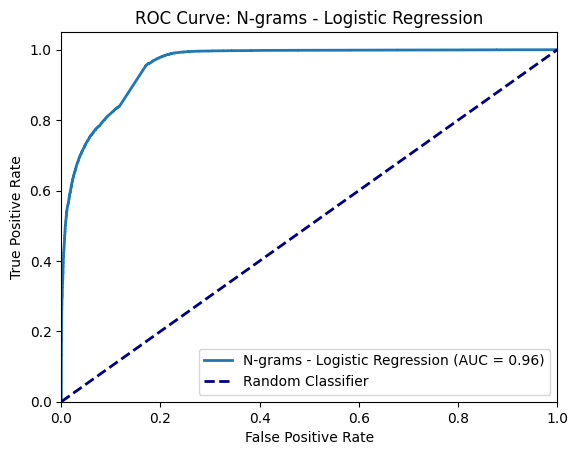

In [14]:
# Initialize and train Logistic Regression model using n-gram features
lr_model_ngrams = LogisticRegression()
lr_model_ngrams.fit(X_train_ngram, y_train)

# Get predicted probabilities for the positive class
y_score_ngrams = lr_model_ngrams.predict_proba(X_test_ngram)[:, 1]

# Compute ROC curve and AUC
fpr_ngrams, tpr_ngrams, _ = roc_curve(y_test, y_score_ngrams)
roc_auc_ngrams = auc(fpr_ngrams, tpr_ngrams)

# Plot ROC curve
plt.figure()
plt.plot(fpr_ngrams, tpr_ngrams, lw=2,
         label='N-grams - Logistic Regression (AUC = {:.2f})'.format(roc_auc_ngrams))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: N-grams - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


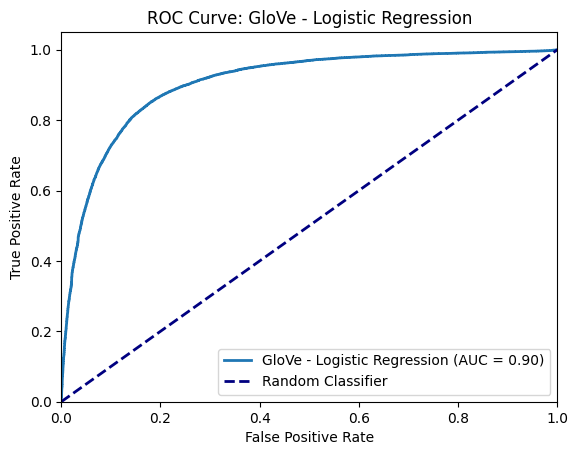

In [15]:
# Train the model (assumes X_train_glove is already prepared)
lr_model_glove = LogisticRegression()
lr_model_glove.fit(X_train_glove, y_train)

# Get predicted probabilities for the positive class
y_score_glove = lr_model_glove.predict_proba(X_test_glove)[:, 1]

# Compute ROC curve and AUC
fpr_glove, tpr_glove, _ = roc_curve(y_test, y_score_glove)
roc_auc_glove = auc(fpr_glove, tpr_glove)

# Plot ROC curve for GloVe
plt.figure()
plt.plot(fpr_glove, tpr_glove, lw=2,
         label='GloVe - Logistic Regression (AUC = {:.2f})'.format(roc_auc_glove))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: GloVe - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


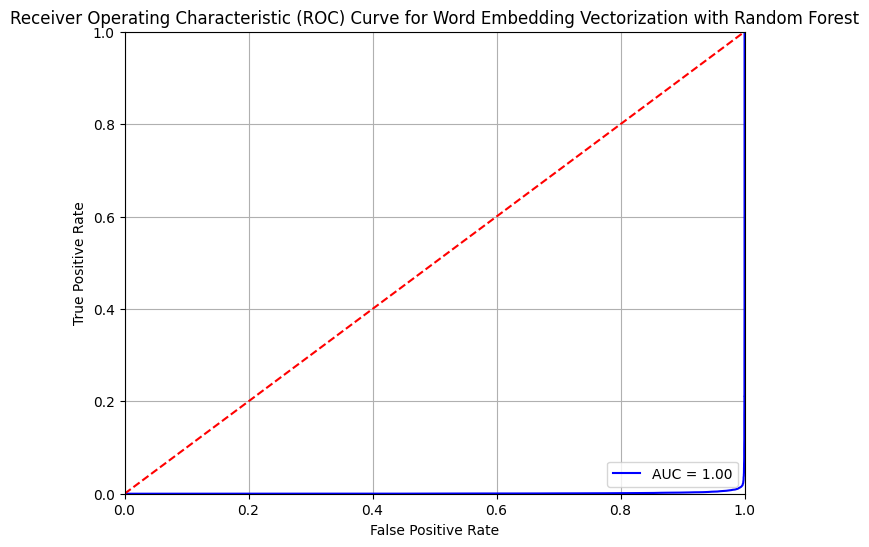

In [18]:
######EVALUATION USING ROC CURVE FOR WORD EMBEDDING VECTORISATION METHOD USING RANDOM FOREST
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


# Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in data['sentence']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
'''
# Function to get word embeddings
def get_sentence_embedding(sentence):
    tokens = word_tokenize(sentence)
    embeddings = []
    for token in tokens:
        if token in word2vec_model.wv:
            embeddings.append(word2vec_model.wv[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

X = np.array([get_sentence_embedding(sentence) for sentence in data['sentence']])

X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
'''
rf_model.fit(X_train, y_train)

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label="question")

roc_auc = roc_auc_score(y_test, y_pred_proba)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Word Embedding Vectorization with Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Bernoulli Naive Bayes (TF-IDF) AUC: 0.9632


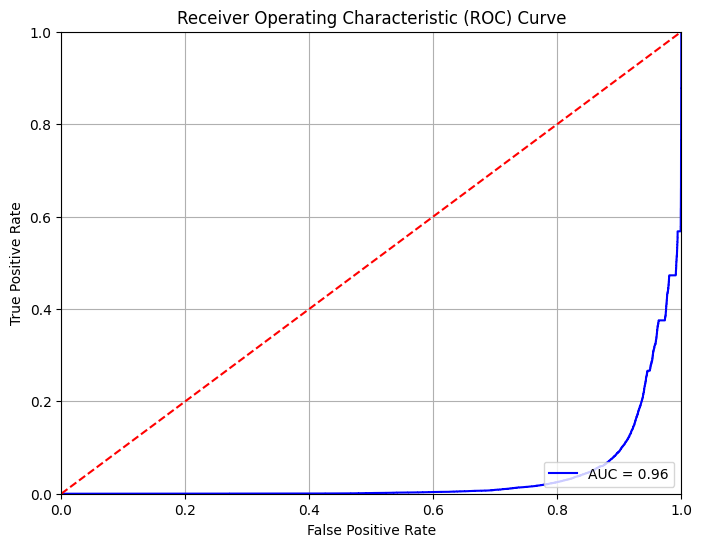

In [ ]:
# Evaluation of TF-IDF vectorisation using Bernoulli Naive bayes
# TF-IDF Vectorization
from sklearn.naive_bayes import BernoulliNB
tfidf_vectorizer = TfidfVectorizer()

nb_model = BernoulliNB()


nb_model.fit(X_train_tfidf, y_train)

y_pred_proba = nb_model.predict_proba(X_test_tfidf)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
model_name = 'Bernoulli Naive Bayes (TF-IDF)'
print(f"{model_name} AUC: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label="question")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Bernoulli Naive Bayes (Word2Vec) AUC: 0.9033


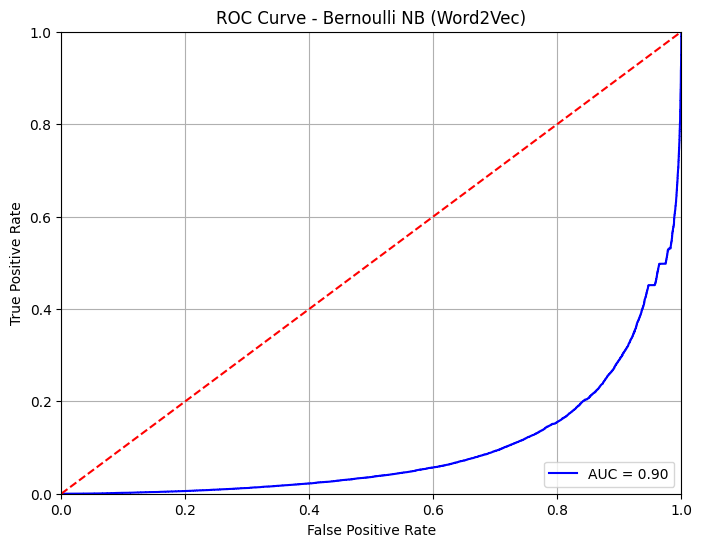

In [20]:
from sklearn.naive_bayes import BernoulliNB

# Initialize and train the Bernoulli Naive Bayes model
nb_model_word2vec = BernoulliNB()
nb_model_word2vec.fit(X_train_w2v, y_train)

# Predict probabilities for the positive class
y_pred_proba_word2vec = nb_model_word2vec.predict_proba(X_test_w2v)[:, 1]

# Compute AUC
auc_word2vec = roc_auc_score(y_test, y_pred_proba_word2vec)
print(f"Bernoulli Naive Bayes (Word2Vec) AUC: {auc_word2vec:.4f}")

# Compute ROC curve
fpr_word2vec, tpr_word2vec, _ = roc_curve(y_test, y_pred_proba_word2vec, pos_label="question")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_word2vec, tpr_word2vec, color='b', label=f'AUC = {auc_word2vec:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bernoulli NB (Word2Vec)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Bernoulli Naive Bayes (GloVe) AUC: 0.7994


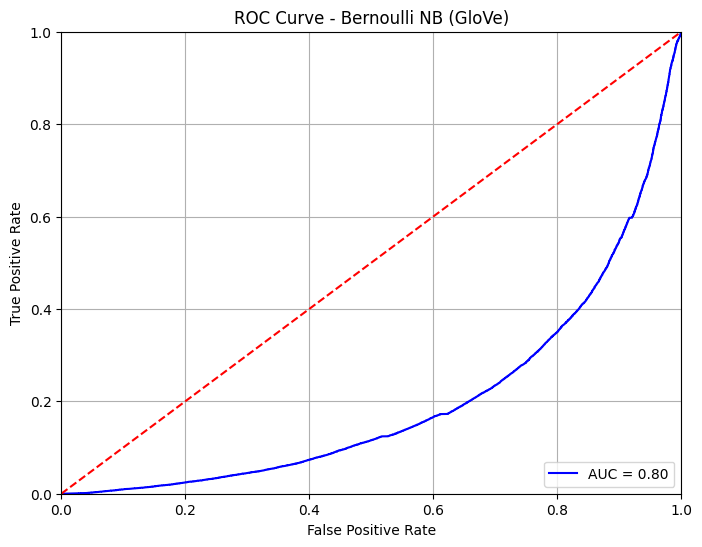

In [21]:

# Initialize and train the Bernoulli Naive Bayes model
nb_model_glove = BernoulliNB()
nb_model_glove.fit(X_train_glove, y_train)

# Predict probabilities for the positive class
y_pred_proba_glove = nb_model_glove.predict_proba(X_test_glove)[:, 1]

# Compute AUC
auc_glove = roc_auc_score(y_test, y_pred_proba_glove)
print(f"Bernoulli Naive Bayes (GloVe) AUC: {auc_glove:.4f}")

# Compute ROC curve
fpr_glove, tpr_glove, _ = roc_curve(y_test, y_pred_proba_glove, pos_label="question")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_glove, tpr_glove, color='b', label=f'AUC = {auc_glove:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bernoulli NB (GloVe)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Bernoulli Naive Bayes (N-grams) AUC: 0.9450


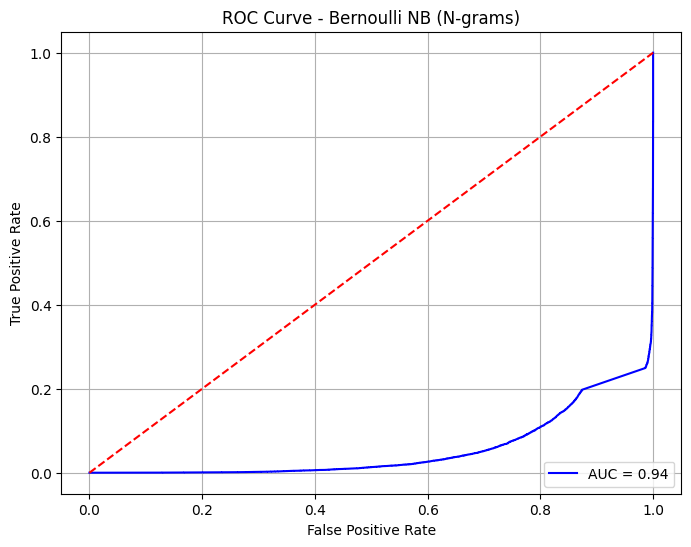

In [25]:
nb_model_ngram = BernoulliNB()
nb_model_ngram.fit(X_train_ngram, y_train)

# Predict probabilities for the positive class (assumed to be labeled "question")
y_pred_proba_ngram = nb_model_ngram.predict_proba(X_test_ngram)[:, 1]
auc_ngram = roc_auc_score(y_test, y_pred_proba_ngram)
print(f"Bernoulli Naive Bayes (N-grams) AUC: {auc_ngram:.4f}")

# Compute ROC curve
fpr_ngram, tpr_ngram, _ = roc_curve(y_test, y_pred_proba_ngram, pos_label="question")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ngram, tpr_ngram, color='b', label=f'AUC = {auc_ngram:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bernoulli NB (N-grams)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
